In [1]:
import numpy as np
from xgboost import XGBRanker
from sklearn.metrics import ndcg_score
import matplotlib.pyplot as plt
import psycopg2
from gensim.models.doc2vec import Doc2Vec
from gensim.utils import simple_preprocess
import tensorflow as tf
import tensorflow.keras.backend as K
from faiss import read_index
from psycopg2.extras import execute_values
import pickle
import pandas as pd
import seaborn as sns
from operator import itemgetter
from utils.utils import get_q_answers

plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = r"\usepackage{amsmath}"

2024-06-28 11:22:53.713913: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Load fair rank

In [2]:
connection = psycopg2.connect(
    user="postgres",
    password="postgres",
    host="127.0.0.1",
    port="54320",
    database="stack_overflow",
)

In [3]:
after_fair_df = pd.read_csv("after_fair_data.csv")
after_fair_df.head()

,q_id,u_id,developed_country,idx,pscore
0,70547027,100297,1,0,2.340971
1,70547027,7574575,0,1,2.266549
2,70547027,11923558,0,2,2.071728
3,70547027,1624921,1,3,2.033441
4,70547027,325565,1,4,1.930067


In [4]:
with connection:
    with connection.cursor() as cursor:
        execute_values(
            cursor,
            """select q_id, u_id, q_a.score
            FROM (VALUES %s) AS base_questions (q_id, u_id)
            JOIN posts_19 q_a ON q_a.parent_id = q_id
            WHERE q_a.owner_user_id=u_id""",
            after_fair_df[["q_id", "u_id"]].values.tolist(),
            page_size=len(after_fair_df),
        )
        answers_dataset = pd.DataFrame(
            cursor.fetchall(), columns=["q_id", "u_id", "score"]
        )

In [11]:
full_dataset = after_fair_df.merge(answers_dataset, on=["q_id", "u_id"], how="left")
full_dataset["is_answer"] = (~full_dataset["score"].isna()).astype(int)
full_dataset = full_dataset.sort_values(by=["q_id", "pscore"], ascending=False)
full_dataset[full_dataset["is_answer"]==0].head()

,q_id,u_id,developed_country,idx,pscore,score,is_answer
397200,74681417,100297,1,0,2.263848,NaN,0
397201,74681417,3874623,1,1,2.024328,NaN,0
397202,74681417,5923139,1,2,1.902712,NaN,0
397203,74681417,7574575,0,3,1.897878,NaN,0
397204,74681417,325565,1,4,1.845899,NaN,0


In [12]:
full_dataset = after_fair_df.merge(answers_dataset, on=["q_id", "u_id"], how="left")
full_dataset["is_answer"] = (~full_dataset["score"].isna()).astype(int)
full_dataset = full_dataset.sort_values(by=["q_id", "pscore"], ascending=False)
full_dataset[full_dataset["is_answer"]==1].head()

,q_id,u_id,developed_country,idx,pscore,score,is_answer
396621,74671391,235698,0,21,1.588857,1.0,1
395676,74659510,5459839,1,76,1.393546,0.0,1
395122,74651157,494134,1,22,1.602037,0.0,1
393637,74632313,364696,1,37,1.377957,0.0,1
392995,74620209,5459839,1,95,1.359678,3.0,1


In [13]:
full_dataset["is_answer"].sum()

444

# Evaluate recall

In [14]:
posts_ids = full_dataset["q_id"].unique().tolist()
len(posts_ids)

3973

In [15]:
q_answers_dev_country, q_answers_no_dev_country = get_q_answers(connection, tuple(posts_ids))
len(q_answers_dev_country), len(q_answers_no_dev_country)

(2788, 2806)

In [17]:
len(after_fair_df[after_fair_df["developed_country"] == 0]["u_id"].unique())

507

In [18]:
len(after_fair_df["u_id"].unique())

936

In [ ]:
with connection:
    with connection.cursor() as cursor:
        cursor.execute("""select q_a.parent_id, q_a.owner_user_id
                            FROM posts_19 q_a
                            where q_a.parent_id in %s""",
                                (tuple(posts_ids),))
        q_answers_users = pd.DataFrame(cursor.fetchall(), columns=["qid", "uid"])

In [ ]:
len(q_answers_users), len(q_answers_users.groupby("qid").count())

In [ ]:
q_answers_2 = q_answers_users.groupby("qid").count()
q_answers_2dict = q_answers_2["uid"].to_dict()

In [ ]:
q_id_errors = []
for q_id, answers in q_answers_2dict.items():
    if answers != q_answers.get(q_id, 0):
        q_id_errors.append(q_id)

In [ ]:
q_answers_users[q_answers_users["uid"].isin(users_dev_country)]

In [ ]:
users = pd.read_csv("users_dev_country.csv")

In [ ]:
users_dev_country = users[users["developed_country"] == 1]["user_id"].tolist()

with connection:
    with connection.cursor() as cursor:
        cursor.execute("""select q_a.parent_id, count(*) as answers
                            FROM posts_19 q_a
                            JOIN users u ON q_a.owner_user_id=u.id
                            where q_a.parent_id in %s
                            AND u.id in %s
                            group by q_a.parent_id""",
                       (tuple(posts_ids), tuple(users_dev_country)))
        q_answers_dev_country = cursor.fetchall()
q_answers_dev_country = {q_id: answers for q_id, answers in q_answers_dev_country}

In [ ]:
users_no_dev_country = users[users["developed_country"] == 0]["user_id"].tolist()

with connection:
    with connection.cursor() as cursor:
        cursor.execute("""select q_a.parent_id, count(*) as answers
                            FROM posts_19 q_a
                            JOIN users u ON q_a.owner_user_id=u.id
                            where q_a.parent_id in %s
                            AND u.id in %s
                            group by q_a.parent_id""",
                                (tuple(posts_ids), tuple(users_no_dev_country)))
        q_answers_no_dev_country = cursor.fetchall()
q_answers_no_dev_country = {q_id: answers for q_id, answers in q_answers_no_dev_country}

In [39]:
no_dev_df = pd.DataFrame(list(q_answers_no_dev_country.values()), columns=["value"])
no_dev_df["dev"] = 0
dev_df = pd.DataFrame(list(q_answers_dev_country.values()), columns=["value"])
dev_df["dev"] = 1

base_count_df = pd.concat([no_dev_df, dev_df])
base_count_df.head()

,value,dev
0,1,0
1,2,0
2,2,0
3,2,0
4,2,0


<Axes: xlabel='value', ylabel='count'>

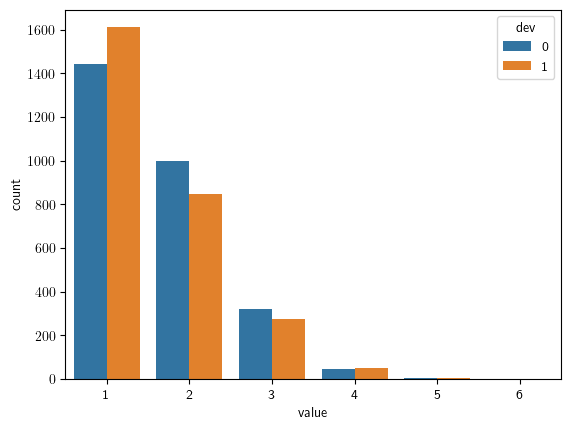

In [42]:
sns.countplot(base_count_df,x="value",hue="dev")

In [ ]:
top_k = range(0, 101, 2)

dev_dataset = full_dataset[full_dataset["developed_country"] == 1]
no_dev_dataset = full_dataset[full_dataset["developed_country"] == 0]

dev_mean_recall = []
no_dev_mean_recall = []
for k in top_k:    
    dev_recall = (dev_dataset[["is_answer", "q_id", "idx"]]
        .groupby("q_id")
        .apply(
            lambda x: (
                x[x["idx"] <= k]["is_answer"].sum()
            )
        )
        .dropna())
    dev_mean_recall.append(dev_recall.sum())
    
    
    no_dev_recall = (no_dev_dataset[["is_answer", "q_id", "idx"]]
        .groupby("q_id")
        .apply(
            lambda x: (
                x[x["idx"] <= k]["is_answer"].sum()
            )
        )
        .dropna()
    )
    no_dev_mean_recall.append(no_dev_recall.sum())
    

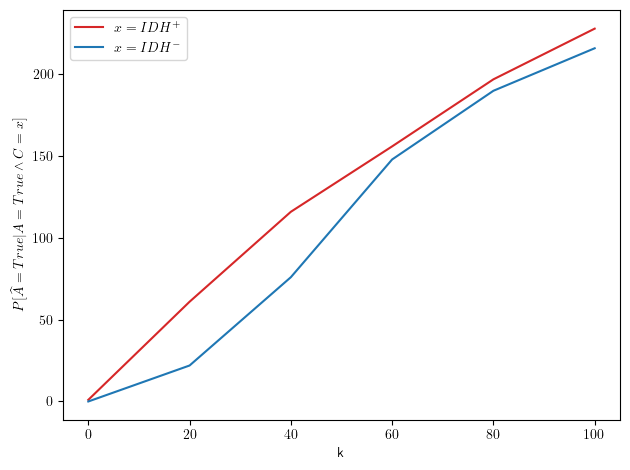

In [45]:
fig, ax1 = plt.subplots()

color = "tab:red"
ax1.set_xlabel("k")
ax1.set_ylabel("$P[\widehat{A}=True|A=True \land C=x]$")
ax1.plot(top_k, dev_mean_recall, color=color, label="$x=IDH^+$")
ax1.plot(top_k, no_dev_mean_recall, color="tab:blue", label="$x=IDH^-$")
ax1.legend(loc="upper left")

fig.tight_layout()

In [47]:
top_k = range(0, 101, 2)

dev_dataset = full_dataset[full_dataset["developed_country"] == 1]
no_dev_dataset = full_dataset[full_dataset["developed_country"] == 0]

dev_mean_recall = []
no_dev_mean_recall = []
for k in top_k:    
    dev_recall = (dev_dataset[["is_answer", "q_id", "idx"]]
        .groupby("q_id")
        .apply(
            lambda x: (
                x[x["idx"] <= k]["is_answer"].sum()
                / q_answers_dev_country[x["q_id"].iloc[0]]
                if x["q_id"].iloc[0] in q_answers_dev_country
                else np.NaN
            )
        )
        .dropna())
    dev_mean_recall.append(dev_recall.mean())
    
    
    no_dev_recall = (no_dev_dataset[["is_answer", "q_id", "idx"]]
        .groupby("q_id")
        .apply(
            lambda x: (
                x[x["idx"] <= k]["is_answer"].sum()
                / q_answers_no_dev_country[x["q_id"].iloc[0]]
                if x["q_id"].iloc[0] in q_answers_no_dev_country
                else np.NaN
            )
        )
        .dropna()
    )
    no_dev_mean_recall.append(no_dev_recall.mean())
    

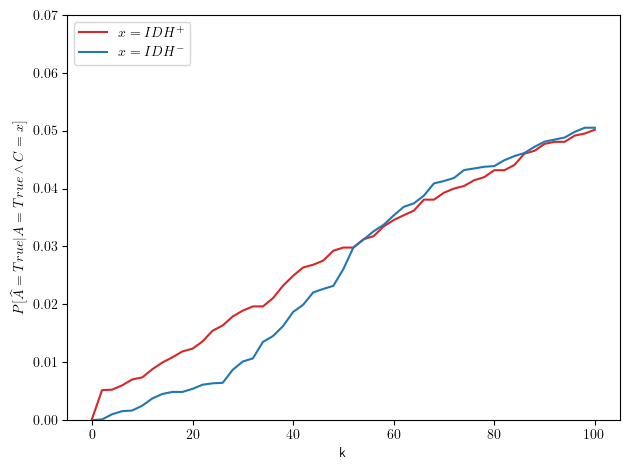

In [48]:
fig, ax1 = plt.subplots()

color = "tab:red"
ax1.set_xlabel("k")
ax1.set_ylabel("$P[\widehat{A}=True|A=True \land C=x]$")
ax1.plot(top_k, dev_mean_recall, color=color, label="$x=IDH^+$")
ax1.plot(top_k, no_dev_mean_recall, color="tab:blue", label="$x=IDH^-$")
ax1.set_ylim(0, 0.07)
ax1.legend(loc="upper left")

fig.tight_layout()
fig.savefig("recall_mean_after.pdf")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


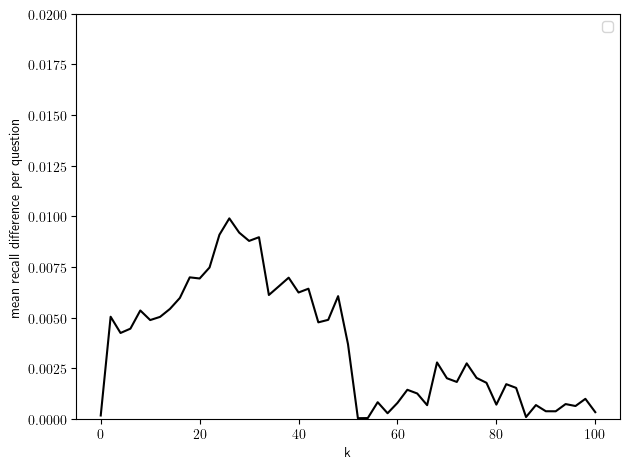

In [49]:
fig, ax1 = plt.subplots()

dev_mean_recall_difference = [np.absolute(k_dev_mean_recall - k_no_dev_mean_recall)
                             for k_dev_mean_recall, k_no_dev_mean_recall
                             in zip(dev_mean_recall, no_dev_mean_recall)]
color = "black"
ax1.set_xlabel("k")
ax1.set_ylabel("mean recall difference per question")
ax1.plot(top_k, dev_mean_recall_difference, color=color)
ax1.set_ylim(0, 0.02)
ax1.legend()

fig.tight_layout()
fig.savefig("recall_difference_after.pdf")

In [51]:
for k in (20, 60, 100):
    print(f"The mean recall in high HDI countries in the top {top_k[k//2]} "
          f"is {dev_mean_recall[k//2]}")
    print(f"The mean recall in low HDI countries in the top {top_k[k//2]} "
          f"is {no_dev_mean_recall[k//2]}")
    print("The mean recall difference in low HDI countries vs high HDI"
          f"in the top {top_k[k//2]} "
          f"is {dev_mean_recall_difference[k//2]}")

The mean recall in high HDI countries in the top 20 is 0.012344571975131516
The mean recall in low HDI countries in the top 20 is 0.005405084343074363
The mean recall difference in low HDI countries vs high HDIin the top 20 is 0.0069394876320571525
The mean recall in high HDI countries in the top 60 is 0.034552845528455285
The mean recall in low HDI countries in the top 60 is 0.0353528153955809
The mean recall difference in low HDI countries vs high HDIin the top 60 is 0.000799969867125612
The mean recall in high HDI countries in the top 100 is 0.05015542802486848
The mean recall in low HDI countries in the top 100 is 0.05049893086243763
The mean recall difference in low HDI countries vs high HDIin the top 100 is 0.0003435028375691554


In [52]:
max_difference_index = 13
print(f"The maximum difference in recall is in k {top_k[max_difference_index]} "
      f"with {dev_mean_recall_difference[max_difference_index]}")

The maximum difference in recall is in k 26 with 0.009905308976153784


In [53]:
with connection:
    with connection.cursor() as cursor:
        cursor.execute(
            """SELECT q_a.parent_id, count(*) as answers
                FROM posts_19 q_a
                JOIN users u ON q_a.owner_user_id=u.id
                where q_a.parent_id in %s
                group by q_a.parent_id, u.high_hdi""",
            (tuple(posts_ids),),
        )
        q_answers_result = cursor.fetchall()

q_answers = {q_id: count_answers for q_id, count_answers in q_answers_result}

In [54]:
top_k = range(0, 101)

mean_recall = []
for k in top_k:    
    k_recall = (full_dataset[["is_answer", "q_id", "idx"]]
        .groupby("q_id")
        .apply(
            lambda x: (
                x[x["idx"] <= k]["is_answer"].sum()
                / q_answers[x["q_id"].iloc[0]]
                if x["q_id"].iloc[0] in q_answers
                else np.NaN
            )
        )
        .dropna())
    mean_recall.append(k_recall.mean())



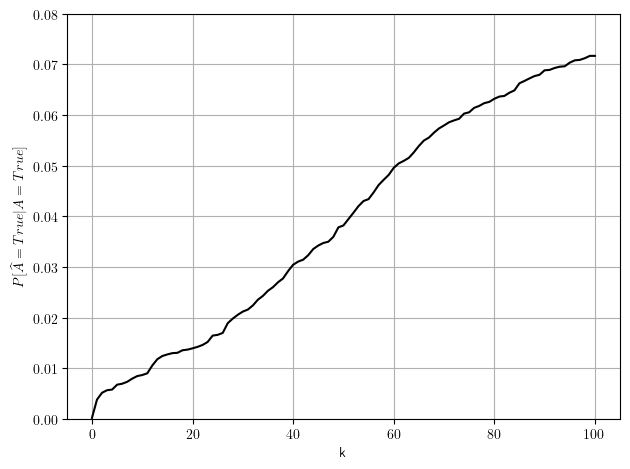

In [55]:
fig, ax1 = plt.subplots()

color = "black"
ax1.set_xlabel("k")
ax1.set_ylabel("$P[\widehat{A}=True|A=True]$")
ax1.plot(top_k, mean_recall, color=color)
ax1.set_ylim(0, 0.08)
ax1.grid()

fig.tight_layout()
fig.savefig("recall_mean_after_all.pdf")